# Table of Contents

1. [Data Import & Manipulation](#1.-Data-Import-&-Manipulation) 
    1. [Fuel Output & Demand Data](#A.-Fuel-Output-&-Demand-Data)
    2. [HOEP Data](#B.-HOEP-Data)
    3. [NG Production & Demand Data](#C.-NG-Production-&-Demand-Data)
    4. [Transportation Demand Data](#D.-Transportation-Demand-Data)
    5. [Industry Demand Data](#E.-Industry-Demand-Data)
    6. [Input-Data-to-MILP](#F.-Input-Data-to-MILP)
2. [Mixed Integer Linear Programming](#2.-Mixed-Integer-Linear-Programming)

# Libraries

In [1]:
import pandas as pd

# Variables 

In [2]:
raw=pd.read_csv('Variables.csv')
raw2=raw.dropna(axis='columns',how='all')
var=raw2.dropna(axis='rows',how='all')
var.set_index("variable_name",inplace=True)

In [3]:
var.head()

,value,unit,source,comment
variable_name,,,,
electrolyzer_eff,0.7667,dimensionless,eqtn 3.1,NaN
E_hhv_h2,3.5500,kWh/m^3 H2,eqtn 3.1,NaN
E_rated_h2,4.6300,kWh/m^3 H2,eqtn 3.1,NaN
min_E_cap,0.0000,kWh,eqtn 3.3,NaN
max_E_cap,1000.0000,kWh,eqtn 3.3,NaN


# 1. Data Import & Manipuation

## A. Fuel Output & Demand Data

Fuel output by sources (i.e. nuclear, gas, hydro)

In [4]:
fuel_output = pd.read_csv('on_fuel_source_output_2017.csv', keep_default_na=False, na_values=[""])

Fuel demand in Onatrio 

In [5]:
fuel_demand = pd.read_csv('on_demand_2017.csv', keep_default_na=False, na_values=[""])

In [6]:
fuel_output.head()

,Date,Hour,Fuel,Output
0,2017-01-01,1,NUCLEAR,11592
1,2017-01-01,1,GAS,234
2,2017-01-01,1,HYDRO,2455
3,2017-01-01,1,WIND,2433
4,2017-01-01,1,SOLAR,0


subtract 1 hour because we want 0 to 23 hr 

In [7]:
fuel_output['Hour'] = fuel_output['Hour'] - 1

In [8]:
fuel_output.head()

,Date,Hour,Fuel,Output
0,2017-01-01,0,NUCLEAR,11592
1,2017-01-01,0,GAS,234
2,2017-01-01,0,HYDRO,2455
3,2017-01-01,0,WIND,2433
4,2017-01-01,0,SOLAR,0


In [9]:
fuel_demand.head()

,Date,Hour,Ontario Demand,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Zone Total,Diff
0,2017-01-01,1,13522,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,268"
1,2017-01-01,2,13117,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,673"
2,2017-01-01,3,12816,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,974"
3,2017-01-01,4,12605,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,186"
4,2017-01-01,5,12563,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,227"


In [10]:
fuel_demand['Hour'] = fuel_demand['Hour'] -1

In [11]:
fuel_demand.head()

,Date,Hour,Ontario Demand,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Zone Total,Diff
0,2017-01-01,0,13522,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,268"
1,2017-01-01,1,13117,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,673"
2,2017-01-01,2,12816,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,974"
3,2017-01-01,3,12605,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,186"
4,2017-01-01,4,12563,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,227"


Create Datetime columns in both df

In [12]:
fuel_output['Datetime'] = pd.to_datetime(fuel_output['Date']) + pd.to_timedelta(fuel_output['Hour'], unit='h')

In [13]:
fuel_output.head()

,Date,Hour,Fuel,Output,Datetime
0,2017-01-01,0,NUCLEAR,11592,2017-01-01
1,2017-01-01,0,GAS,234,2017-01-01
2,2017-01-01,0,HYDRO,2455,2017-01-01
3,2017-01-01,0,WIND,2433,2017-01-01
4,2017-01-01,0,SOLAR,0,2017-01-01


In [14]:
fuel_demand['Datetime'] = pd.to_datetime(fuel_demand['Date']) + pd.to_timedelta(fuel_demand['Hour'], unit='h')

In [15]:
fuel_demand.head()

,Date,Hour,Ontario Demand,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Zone Total,Diff,Datetime
0,2017-01-01,0,13522,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,268",2017-01-01 00:00:00
1,2017-01-01,1,13117,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,673",2017-01-01 01:00:00
2,2017-01-01,2,12816,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,974",2017-01-01 02:00:00
3,2017-01-01,3,12605,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,186",2017-01-01 03:00:00
4,2017-01-01,4,12563,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,227",2017-01-01 04:00:00


Groupby Datetime

In [16]:
fuel_output_total = pd.DataFrame(fuel_output.groupby('Datetime')['Output'].sum())
fuel_output_total.columns = ['fuel_total']

In [17]:
fuel_output_total.head()

,fuel_total
Datetime,
2017-01-01 00:00:00,16715
2017-01-01 01:00:00,16344
2017-01-01 02:00:00,15942
2017-01-01 03:00:00,15727
2017-01-01 04:00:00,15653


Set index using Datetime

In [18]:
fuel_demand.set_index('Datetime',inplace=True)

In [19]:
fuel_demand.head()

,Date,Hour,Ontario Demand,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Zone Total,Diff
Datetime,,,,,,,,,,,,,,,
2017-01-01 00:00:00,2017-01-01,0,13522,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,268"
2017-01-01 01:00:00,2017-01-01,1,13117,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,673"
2017-01-01 02:00:00,2017-01-01,2,12816,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,974"
2017-01-01 03:00:00,2017-01-01,3,12605,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,186"
2017-01-01 04:00:00,2017-01-01,4,12563,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,227"


Create SBG data by joining the two data and taking the difference

In [20]:
SBG = pd.merge(fuel_output_total[['fuel_total']],fuel_demand[['Ontario Demand']], how='inner',left_index=True, right_index=True)

In [21]:
SBG.head()

,fuel_total,Ontario Demand
Datetime,,
2017-01-01 00:00:00,16715,13522
2017-01-01 01:00:00,16344,13117
2017-01-01 02:00:00,15942,12816
2017-01-01 03:00:00,15727,12605
2017-01-01 04:00:00,15653,12563


In [22]:
SBG['Difference'] = SBG['fuel_total'] - SBG['Ontario Demand']

In [23]:
SBG.head()

,fuel_total,Ontario Demand,Difference
Datetime,,,
2017-01-01 00:00:00,16715,13522,3193
2017-01-01 01:00:00,16344,13117,3227
2017-01-01 02:00:00,15942,12816,3126
2017-01-01 03:00:00,15727,12605,3122
2017-01-01 04:00:00,15653,12563,3090


Check if there's any cell with difference less than 0

In [24]:
SBG[SBG['Difference']<0].count()

fuel_total        697
Ontario Demand    697
Difference        697
dtype: int64

Assign negative numbers with 0's 

In [25]:
SBG.loc[SBG['Difference']<=0,'Difference'] = 0

In [26]:
SBG[SBG['Difference']<0].count()

fuel_total        0
Ontario Demand    0
Difference        0
dtype: int64

Convert SBG MWh to KWh

In [27]:
SBG['Difference'] = SBG['Difference']*1000

Export the SBG data to a csv file

In [28]:
SBG.columns = ['fuel_output','fuel_demand','SBG(kWh)']

In [29]:
SBG.head()

,fuel_output,fuel_demand,SBG(kWh)
Datetime,,,
2017-01-01 00:00:00,16715,13522,3193000
2017-01-01 01:00:00,16344,13117,3227000
2017-01-01 02:00:00,15942,12816,3126000
2017-01-01 03:00:00,15727,12605,3122000
2017-01-01 04:00:00,15653,12563,3090000


## B. HOEP Data

HOEP values are reported as $/Mwh

In [30]:
hoep_data = pd.read_csv('HOEP_2017.csv', keep_default_na=False, na_values=[""])

In [31]:
hoep_data.head()

,Date,Hour,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min
0,2017-01-01,1,0.0,5.94,0.0,0.0,NaN,NaN,NaN
1,2017-01-01,2,0.0,0.00,2.2,0.0,NaN,NaN,NaN
2,2017-01-01,3,0.0,0.00,0.0,0.0,NaN,NaN,NaN
3,2017-01-01,4,0.0,0.00,0.0,0.0,NaN,NaN,NaN
4,2017-01-01,5,0.0,0.00,0.0,0.0,NaN,NaN,NaN


In [32]:
hoep_data['Hour'] = hoep_data['Hour'] -1

In [33]:
hoep_data['Datetime'] = pd.to_datetime(hoep_data['Date']) + pd.to_timedelta(hoep_data['Hour'], unit='h')

In [34]:
hoep_data.head()

,Date,Hour,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min,Datetime
0,2017-01-01,0,0.0,5.94,0.0,0.0,NaN,NaN,NaN,2017-01-01 00:00:00
1,2017-01-01,1,0.0,0.00,2.2,0.0,NaN,NaN,NaN,2017-01-01 01:00:00
2,2017-01-01,2,0.0,0.00,0.0,0.0,NaN,NaN,NaN,2017-01-01 02:00:00
3,2017-01-01,3,0.0,0.00,0.0,0.0,NaN,NaN,NaN,2017-01-01 03:00:00
4,2017-01-01,4,0.0,0.00,0.0,0.0,NaN,NaN,NaN,2017-01-01 04:00:00


In [35]:
hoep_data.set_index('Datetime',inplace=True)

In [36]:
hoep_data.head(10)

,Date,Hour,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min
Datetime,,,,,,,,,
2017-01-01 00:00:00,2017-01-01,0,0.00,5.94,0.00,0.00,NaN,NaN,NaN
2017-01-01 01:00:00,2017-01-01,1,0.00,0.00,2.20,0.00,NaN,NaN,NaN
2017-01-01 02:00:00,2017-01-01,2,0.00,0.00,0.00,0.00,NaN,NaN,NaN
2017-01-01 03:00:00,2017-01-01,3,0.00,0.00,0.00,0.00,NaN,NaN,NaN
2017-01-01 04:00:00,2017-01-01,4,0.00,0.00,0.00,0.00,NaN,NaN,NaN
2017-01-01 05:00:00,2017-01-01,5,0.00,0.01,0.00,1.99,NaN,NaN,NaN
2017-01-01 06:00:00,2017-01-01,6,0.00,5.94,6.04,6.02,NaN,NaN,NaN
2017-01-01 07:00:00,2017-01-01,7,1.71,6.74,8.42,6.74,NaN,NaN,NaN
2017-01-01 08:00:00,2017-01-01,8,0.00,5.74,5.70,5.84,NaN,NaN,NaN


HOEP data is dollar/Mwh so need to convert to dollar/kWh

In [37]:
hoep_data['HOEP']= hoep_data['HOEP']/1000

In [38]:
input_df = pd.merge(SBG[['SBG(kWh)']],hoep_data[['HOEP']], how='inner',left_index=True, right_index=True)

In [39]:
input_df.head(10)

,SBG(kWh),HOEP
Datetime,,
2017-01-01 00:00:00,3193000,0.00000
2017-01-01 01:00:00,3227000,0.00000
2017-01-01 02:00:00,3126000,0.00000
2017-01-01 03:00:00,3122000,0.00000
2017-01-01 04:00:00,3090000,0.00000
2017-01-01 05:00:00,2898000,0.00000
2017-01-01 06:00:00,2739000,0.00000
2017-01-01 07:00:00,2726000,0.00171
2017-01-01 08:00:00,2267000,0.00000


## C. NG Production & Demand Data

In [40]:
NG_hourly_distribution = pd.read_csv('NG_hourly_distribution.csv')

In [41]:
NG_hourly_distribution.head()

,hour,hourly_distribution
0,1,105
1,2,100
2,3,95
3,4,95
4,5,100


In [42]:
NG_hourly_distribution['ratio'] = NG_hourly_distribution['hourly_distribution']/sum(NG_hourly_distribution['hourly_distribution'])

In [43]:
NG_hourly_distribution['hour'] = NG_hourly_distribution['hour']-1

In [44]:
NG_hourly_distribution.head()

,hour,hourly_distribution,ratio
0,0,105,0.033113
1,1,100,0.031536
2,2,95,0.029959
3,3,95,0.029959
4,4,100,0.031536


In [45]:
NG_monthly_production = pd.read_csv('NG_monthly_production.csv')

In [46]:
NG_monthly_production.head()

,month,NG_production(e3m3/d)
0,1,6184
1,2,6165
2,3,6168
3,4,5978
4,5,6170


In [47]:
input_df['NG_demand(m^3)'] = 0
input_df['NG_demand(m^3)'] = input_df['NG_demand(m^3)'].astype(float)
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3)
Datetime,,,
2017-01-01 00:00:00,3193000,0.0,0.0
2017-01-01 01:00:00,3227000,0.0,0.0
2017-01-01 02:00:00,3126000,0.0,0.0
2017-01-01 03:00:00,3122000,0.0,0.0
2017-01-01 04:00:00,3090000,0.0,0.0


NG demand calculation

In [48]:
for index, row in input_df.iterrows():
   
    curr_hour = index.hour
    curr_month = index.month 
    ratio = NG_hourly_distribution[NG_hourly_distribution['hour']==curr_hour]['ratio'].iloc[0]
    NG_prod = NG_monthly_production[NG_monthly_production['month']==curr_month]['NG_production(e3m3/d)'].iloc[0]
  
    input_df.loc[index,'NG_demand(m^3)'] = (ratio * NG_prod).round(3)*1000
    

In [49]:
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3)
Datetime,,,
2017-01-01 00:00:00,3193000,0.0,204768.0
2017-01-01 01:00:00,3227000,0.0,195017.0
2017-01-01 02:00:00,3126000,0.0,185266.0
2017-01-01 03:00:00,3122000,0.0,185266.0
2017-01-01 04:00:00,3090000,0.0,195017.0


## D. Transportation Demand Data

In [50]:
mobility_hourly_distribution = pd.read_csv('mobility_hourly_distribution.csv')

In [51]:
mobility_hourly_distribution.head()

,hour,% of daily demand
0,1,1.05
1,2,0.80
2,3,0.70
3,4,0.40
4,5,0.90


In [52]:
mobility_hourly_distribution['hour'] = mobility_hourly_distribution['hour'] -1

In [53]:
mobility_hourly_distribution.head()

,hour,% of daily demand
0,0,1.05
1,1,0.80
2,2,0.70
3,3,0.40
4,4,0.90


264000 kg demand * 1m^3/0.0899kg H2 

In [54]:
mobility_hourly_distribution['demand(m^3)'] = mobility_hourly_distribution['% of daily demand'] / 100 * 264000 /0.0899

In [55]:
mobility_hourly_distribution.head()

,hour,% of daily demand,demand(m^3)
0,0,1.05,30834.260289
1,1,0.80,23492.769744
2,2,0.70,20556.173526
3,3,0.40,11746.384872
4,4,0.90,26429.365962


Weekly profile according to Azadeh's workbook

In [56]:
# weekday number 6= Sunday, 0 = Monday,... 5 = Saturday 
week_profile_dict = {'weekday': [6,0,1,2,3,4,5],
         'factor': [101,94,96,100,105,108,96]}
week_profile_df = pd.DataFrame.from_dict(week_profile_dict)
week_profile_df['factor_fraction'] = week_profile_df['factor']/100
week_profile_df

,factor,weekday,factor_fraction
0,101,6,1.01
1,94,0,0.94
2,96,1,0.96
3,100,2,1.00
4,105,3,1.05
5,108,4,1.08
6,96,5,0.96


In [57]:
input_df['mobility_demand(m^3)'] = 0
input_df['mobility_demand(m^3)'] = input_df['mobility_demand(m^3)'].astype(float)
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3)
Datetime,,,,
2017-01-01 00:00:00,3193000,0.0,204768.0,0.0
2017-01-01 01:00:00,3227000,0.0,195017.0,0.0
2017-01-01 02:00:00,3126000,0.0,185266.0,0.0
2017-01-01 03:00:00,3122000,0.0,185266.0,0.0
2017-01-01 04:00:00,3090000,0.0,195017.0,0.0


In [58]:
for index, row in input_df.iterrows():
    curr_weekday = index.weekday()
    curr_hour = index.hour 
    week_factor = week_profile_df[week_profile_df['weekday']==curr_weekday]['factor_fraction'].iloc[0]
    mob_demand = mobility_hourly_distribution[mobility_hourly_distribution['hour']==curr_hour]['demand(m^3)'].iloc[0]
    input_df.loc[index,'mobility_demand(m^3)'] = mob_demand * week_factor 

In [59]:
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3)
Datetime,,,,
2017-01-01 00:00:00,3193000,0.0,204768.0,31142.602892
2017-01-01 01:00:00,3227000,0.0,195017.0,23727.697442
2017-01-01 02:00:00,3126000,0.0,185266.0,20761.735261
2017-01-01 03:00:00,3122000,0.0,185266.0,11863.848721
2017-01-01 04:00:00,3090000,0.0,195017.0,26693.659622


## E. Industry Demand Data

Total industry production capacity (MSm^3/day)

In [60]:
total_daily_production = 6.3 #MSm^3/day

In [61]:
total_yearly_production = total_daily_production * 365

print(total_yearly_production)

2299.5


Industry demand monthly according to the paper 

In [62]:
ind_demand_dic = {'month': [1,2,3,4,5,6,7,8,9,10,11,12],
         'monthly_demand_hydrogen[kg]': [3.2,2.7,2.4,2.1,2,1.8,1.7,2,2.1,2.7,3,3.3]
         }
monthly_hydrogen_demand = pd.DataFrame.from_dict(ind_demand_dic)
total_hydrogen_demand = monthly_hydrogen_demand['monthly_demand_hydrogen[kg]'].sum()
monthly_hydrogen_demand['percentage'] = monthly_hydrogen_demand['monthly_demand_hydrogen[kg]']/total_hydrogen_demand
monthly_hydrogen_demand['production_capacity[m^3/day]'] = total_yearly_production * monthly_hydrogen_demand['percentage'] * (10**6)
monthly_hydrogen_demand

,month,monthly_demand_hydrogen[kg],percentage,production_capacity[m^3/day]
0,1,3.2,0.110345,2.537379e+08
1,2,2.7,0.093103,2.140914e+08
2,3,2.4,0.082759,1.903034e+08
3,4,2.1,0.072414,1.665155e+08
4,5,2.0,0.068966,1.585862e+08
5,6,1.8,0.062069,1.427276e+08
6,7,1.7,0.058621,1.347983e+08
7,8,2.0,0.068966,1.585862e+08
8,9,2.1,0.072414,1.665155e+08
9,10,2.7,0.093103,2.140914e+08


Creating '0' cells for hourly industry demands

In [63]:
input_df['industry_demand(m^3)'] = 0
input_df['industry_demand(m^3)'] = input_df['industry_demand(m^3)'].astype(float)
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3),industry_demand(m^3)
Datetime,,,,,
2017-01-01 00:00:00,3193000,0.0,204768.0,31142.602892,0.0
2017-01-01 01:00:00,3227000,0.0,195017.0,23727.697442,0.0
2017-01-01 02:00:00,3126000,0.0,185266.0,20761.735261,0.0
2017-01-01 03:00:00,3122000,0.0,185266.0,11863.848721,0.0
2017-01-01 04:00:00,3090000,0.0,195017.0,26693.659622,0.0


number of days in each month

In [64]:
num_days_dic = {'month': [1,2,3,4,5,6,7,8,9,10,11,12],
         'number_of_days': [31,28,31,30,31,30,31,31,30,31,30,31]}
num_days_df = pd.DataFrame.from_dict(num_days_dic)
num_days_df

,month,number_of_days
0,1,31
1,2,28
2,3,31
3,4,30
4,5,31
5,6,30
6,7,31
7,8,31
8,9,30
9,10,31


Create hourly profile for industry demand 

In [65]:
for index, row in input_df.iterrows():
    curr_month = index.month 
    num_days = num_days_df[num_days_df['month']==curr_month]['number_of_days'].iloc[0]
    ind_prod = monthly_hydrogen_demand[monthly_hydrogen_demand['month']==curr_month]['production_capacity[m^3/day]'].iloc[0]
    input_df.loc[index,'industry_demand(m^3)'] = ind_prod / (num_days * 24) * 0.05

In [66]:
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3),industry_demand(m^3)
Datetime,,,,,
2017-01-01 00:00:00,3193000,0.0,204768.0,31142.602892,17052.280311
2017-01-01 01:00:00,3227000,0.0,195017.0,23727.697442,17052.280311
2017-01-01 02:00:00,3126000,0.0,185266.0,20761.735261,17052.280311
2017-01-01 03:00:00,3122000,0.0,185266.0,11863.848721,17052.280311
2017-01-01 04:00:00,3090000,0.0,195017.0,26693.659622,17052.280311


## F. Input Data to MILP

In [67]:
input_df.head(10)

,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3),industry_demand(m^3)
Datetime,,,,,
2017-01-01 00:00:00,3193000,0.00000,204768.0,31142.602892,17052.280311
2017-01-01 01:00:00,3227000,0.00000,195017.0,23727.697442,17052.280311
2017-01-01 02:00:00,3126000,0.00000,185266.0,20761.735261,17052.280311
2017-01-01 03:00:00,3122000,0.00000,185266.0,11863.848721,17052.280311
2017-01-01 04:00:00,3090000,0.00000,195017.0,26693.659622,17052.280311
2017-01-01 05:00:00,2898000,0.00000,214519.0,32625.583982,17052.280311
2017-01-01 06:00:00,2739000,0.00000,273024.0,60802.224694,17052.280311
2017-01-01 07:00:00,2726000,0.00171,282775.0,90461.846496,17052.280311
2017-01-01 08:00:00,2267000,0.00000,243772.0,120121.468298,17052.280311


In [68]:
input_df.reset_index(inplace=True)
input_df.head(10)

,Datetime,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3),industry_demand(m^3)
0,2017-01-01 00:00:00,3193000,0.00000,204768.0,31142.602892,17052.280311
1,2017-01-01 01:00:00,3227000,0.00000,195017.0,23727.697442,17052.280311
2,2017-01-01 02:00:00,3126000,0.00000,185266.0,20761.735261,17052.280311
3,2017-01-01 03:00:00,3122000,0.00000,185266.0,11863.848721,17052.280311
4,2017-01-01 04:00:00,3090000,0.00000,195017.0,26693.659622,17052.280311
5,2017-01-01 05:00:00,2898000,0.00000,214519.0,32625.583982,17052.280311
6,2017-01-01 06:00:00,2739000,0.00000,273024.0,60802.224694,17052.280311
7,2017-01-01 07:00:00,2726000,0.00171,282775.0,90461.846496,17052.280311
8,2017-01-01 08:00:00,2267000,0.00000,243772.0,120121.468298,17052.280311
9,2017-01-01 09:00:00,2324000,0.00000,234021.0,166093.882091,17052.280311


# 2. Mixed Integer Linear Programming

In [79]:
# """
# Model for RNG/NG
# """

# import pulp
# import pandas as pd

# # Time-series constants
# SBG = list(input_df['SBG(kWh)'])
# D = list(input_df['NG_demand(m^3)'])
# HOEP = list(input_df['HOEP'])

# #count number of non-zero SBG hours
# non_zero_SBG_hrs = sum(x > 0 for x in SBG)

# # Fixed constants
# nu_electrolyzer = 3.55 / 4.63 #dimensionless
# E_HHV_H2 = 3.55 #kWh/m^3 H2
# nu_reactor = 213.6 / 4 / 68.7 #dimensionless 

# HHV_H2 = 0.2718 #MMBtu/kmol pdf page 181
# HHV_NG = 0.8053 #MMBtu/kmol pdf page 181 

# #temporarily disabled these 
# #HHV_H2 = 68.7 
# #HHV_NG = 10.55 #0.03623 MMBtu/m^3 & 293.2972222kWh/1MMBtu  = [kwh/m^3]


# CO2_available = 6246451/non_zero_SBG_hrs # m^3/h during non-zero SBG hours 
# E_electrolyzer_min = 0 # kWh
# E_electrolyzer_max = 1000 # kwh
# tau = 0.50 # ramp rate limitation 
# beta = 1.35 # replacement and captial cost factor 
# C_0 = 1324.3 # $/kW
# mu = 0.707 # scaling factor 
# gamma = 1714.8 # $/m^3
# k = 2e6 # $
# C_upgrading = 1172.3 # $/m^3
# C_CO2 = 0.172 # $/m^3
# TC = 0.008804 # $/kWh
# C_H2O = 0.00314 # $/L H2O
# WCR = 0.4 # L/m^3 H2
# OPEX_upgrading = 146.5 #$/m^3


# # MILP model - Cost minimization model 
# LP = pulp.LpProblem('LP', pulp.LpMinimize)


# # MILP variables 
# RNG_max = pulp.LpVariable('RNG_max',
#                           lowBound=0,
#                           cat='Continuous') # m^3/h 

# N_electrolyzer = pulp.LpVariable('N_electrolyzer',
#                                  lowBound=0,
#                                  cat='Integer') # dimensionless 

# alpha = pulp.LpVariable.dicts('alpha',
#                           [str(i) for i in range(1, 31)],
#                           cat='Binary') # dimensionless 

# E = pulp.LpVariable.dicts('E_h',
#                           [str(i) for i in input_df.index],
#                           lowBound=0,
#                           cat='Continuous') # kWh


# H2 = pulp.LpVariable.dicts('H2_h',
#                           [str(i) for i in input_df.index],
#                           lowBound=0,
#                           cat='Continuous') # m^3/h 

# RNG = pulp.LpVariable.dicts('RNG_h',
#                           [str(i) for i in input_df.index],
#                           lowBound=0,
#                           cat='Continuous') # m^3/h 

# CO2 = pulp.LpVariable.dicts('CO2_h',
#                           [str(i) for i in input_df.index],
#                           lowBound=0, 
#                           cat='Continuous') # m^3/h


# NG = pulp.LpVariable.dicts('NG_h',
#                           [str(i) for i in input_df.index],
#                           lowBound=0,
#                           cat='Continuous') # m^3/h 

# # Objective variables 
# CAPEX = pulp.LpVariable('CAPEX', cat='Continuous')
# OPEX = pulp.LpVariable('OPEX', cat='Continuous')


# for i, h in enumerate([str(i) for i in input_df.index]):
#     # Energy and flow constraints

#     if h == '0':
#         LP += RNG_max <= CO2_available
#     LP += H2[h] == nu_electrolyzer * E[h] / E_HHV_H2
#     LP += RNG[h] == nu_reactor * H2[h] * HHV_H2 / HHV_NG
#     LP += CO2[h] == RNG[h]

#     # Demand constraint
#     LP += NG[h] == D[i] - RNG[h]
#     #LP += RNG[h] == D[i]
    
#     # Electrolyzer and reactor constraints
#     LP += N_electrolyzer * E_electrolyzer_min <= E[h]
#     LP += N_electrolyzer * E_electrolyzer_max >= E[h]
#     LP += E[h] <= SBG[i]
#     LP += RNG[h] <= RNG_max
#     if h != '0':
#         LP += -RNG_max * tau <= RNG[h] - RNG[str(i - 1)]
#         LP += RNG_max * tau >= RNG[h] - RNG[str(i - 1)]
#     if h == '0':
#         LP += pulp.lpSum(n * alpha[str(n)] for n in range(1, 31)) == N_electrolyzer
#         LP += pulp.lpSum(alpha) == 1

# # CAPEX
# C_electrolyzer = [beta * C_0 * i ** mu for i in range(1, 31)]
# LP += pulp.lpSum(alpha[str(n)] * C_electrolyzer[n - 1] for n in range(1, 31)) + \
#       gamma * RNG_max + k + C_upgrading * RNG_max == CAPEX

# # OPEX
# LP += pulp.lpSum(CO2[str(n)] * C_CO2 for n in input_df.index) + \
#       pulp.lpSum(E[str(n)] * (HOEP[n] + TC) for n in input_df.index) + \
#       pulp.lpSum(H2[str(n)] * C_H2O * WCR for n in input_df.index) + \
#       OPEX_upgrading * RNG_max == OPEX

# # Objective
# LP += CAPEX + OPEX, 'Z'

# LP.solve()
# print([x.varValue for x in LP.variables()])
# print(pulp.value(LP.objective))

In [69]:
"""
Model for RNG/NG
"""

import pulp
import pandas as pd

# Time-series constants
SBG = list(input_df['SBG(kWh)'])
D = list(input_df['NG_demand(m^3)'])
HOEP = list(input_df['HOEP'])

# Fixed constants
nu_electrolyzer = var['value']['electrolyzer_eff']
E_HHV_H2 = var['value']['E_hhv_h2']
nu_reactor = var['value']['meth_reactor_eff']
HHV_H2 = var['value']['HHV_H2']
HHV_NG = var['value']['HHV_NG']
CO2_available = var['value']['CO2_available']
E_electrolyzer_min = var['value']['min_E_cap']
E_electrolyzer_max = var['value']['max_E_cap']
tau = 0.50

EMF_NG = var['value']['EMF_NG']
EMF_comb = var['value']['EMF_combRNG']
EMF_nuc = var['value']['EMF_nuclear']
EMF_bio = var['value']['EMF_bioCO2']
EMF_electrolyzer = var['value']['EMF_electrolyzer']
EMF_reactor = var['value']['EMF_reactor']

beta = var['value']['beta']
C_0 = var['value']['C_0']
mu = var['value']['mu']
gamma = var['value']['gamma']
k = var['value']['k']
C_upgrading = var['value']['C_upgrading']
C_CO2 = var['value']['C_CO2']
TC = var['value']['TC']
C_H2O = var['value']['C_H2O']
WCR = var['value']['water_cons_rate']
OPEX_upgrading = var['value']['OPEX_upgrading']

# RNG model
LP_1 = pulp.LpProblem('LP', pulp.LpMinimize)

RNG_max = pulp.LpVariable('RNG_max',
                          lowBound=0,
                          cat='Continuous')
N_electrolyzer_1 = pulp.LpVariable('N_electrolyzer_1',
                          lowBound=0,
                          cat='Continuous')
alpha_1 = pulp.LpVariable.dicts('alpha_1',
                          [str(i) for i in range(1, 31)],
                          cat='Binary')

E_1 = pulp.LpVariable.dicts('E_1',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')
H2_1 = pulp.LpVariable.dicts('H2_1',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')
RNG = pulp.LpVariable.dicts('RNG',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')
CO2 = pulp.LpVariable.dicts('CO2_1',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')
NG_1 = pulp.LpVariable.dicts('NG_1',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')

em_offset_max_1 = pulp.LpVariable('em_offset_max_1',
                          lowBound=0,
                          cat='Continuous')
em_rng = pulp.LpVariable('em_rng',
                          lowBound=0,
                          cat='Continuous')
em_ng = pulp.LpVariable('em_ng',
                          lowBound=0,
                          cat='Continuous')

CAPEX_1 = pulp.LpVariable('CAPEX_1', lowBound=0, cat='Continuous')
OPEX_1 = pulp.LpVariable('OPEX_1', lowBound=0, cat='Continuous')

for i, h in enumerate([str(i) for i in input_df.index]):
    # Energy and flow constraints
    if h == '0':
        LP_1 += RNG_max <= CO2_available
    LP_1 += H2_1[h] == nu_electrolyzer * E_1[h] / E_HHV_H2
    LP_1 += RNG[h] == nu_reactor * H2_1[h] * HHV_H2 / HHV_NG
    LP_1 += CO2[h] == RNG[h]

    # Demand constraint
    LP_1 += NG_1[h] == D[i] - RNG[h]

    # Electrolyzer and reactor constraints
    LP_1 += N_electrolyzer_1 * E_electrolyzer_min <= E_1[h]
    LP_1 += N_electrolyzer_1 * E_electrolyzer_max >= E_1[h]
    LP_1 += E_1[h] <= SBG[i]
    LP_1 += RNG[h] <= RNG_max
    if h != '0':
        LP_1 += -RNG_max * tau <= RNG[h] - RNG[str(i - 1)]
        LP_1 += RNG_max * tau >= RNG[h] - RNG[str(i - 1)]
    if h == '0':
        LP_1 += pulp.lpSum(n * alpha_1[str(n)] for n in range(1, 31)) == N_electrolyzer_1
        LP_1 += pulp.lpSum(alpha_1) <= 1

# Emission constraints
LP_1 += pulp.lpSum(EMF_NG * NG_1[h] + EMF_comb * RNG[h] + EMF_nuc * E_1[h] + \
                   EMF_bio * CO2[h] + EMF_electrolyzer * H2_1[h] + EMF_reactor * RNG[h] \
                   for h in [str(x) for x in input_df.index]) == em_rng
LP_1 += pulp.lpSum(EMF_NG * D[h] for h in input_df.index) == em_ng
LP_1 += em_ng - em_rng == em_offset_max_1

# CAPEX
C_electrolyzer = [beta * C_0 * i ** mu for i in range(1, 31)]
LP_1 += pulp.lpSum(alpha_1[str(n)] * C_electrolyzer[n - 1] for n in range(1, 31)) + \
      gamma * RNG_max + k + C_upgrading * RNG_max == CAPEX_1

# OPEX
LP_1 += pulp.lpSum(CO2[str(n)] * C_CO2 for n in input_df.index) + \
      pulp.lpSum(E_1[str(n)] * (HOEP[n] + TC) for n in input_df.index) + \
      pulp.lpSum(H2_1[str(n)] * C_H2O * WCR for n in input_df.index) + \
      OPEX_upgrading * RNG_max == OPEX_1

# Objective
LP_1 += CAPEX_1 + OPEX_1, 'Cost_1'

LP_1.solve()
print([x.varValue for x in LP_1.variables()])
print(pulp.value(LP_1.objective))


[2000000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [72]:
print(LP_1.status)
print(RNG_max.value())
print(N_electrolyzer_1.value())
print(CAPEX_1.value(), OPEX_1.value())

1
0.0
0.0
2000000.0 0.0


In [74]:
#create variable dictionary
variable_dict = {}
for v in LP_1.variables():
    variable_dict[v.name] = v.varValue

In [88]:
def create_var_df(variable_dict,col_string,exc_string=None):
    '''
    variable_dict = dictionary of the variable names and values
    col_string = the variable name of interest (i.e. 'CO2_h_')
    exc_string = the variable you do not want to include (just in case of RNG and RNG_max)
    '''
   
   
    if exc_string is not None:
        #list of variable values
        var_value = [ v for k,v in variable_dict.items() if  (k.startswith(col_string) and exc_string not in k)]
        #list of variable names 
        var_name = [ k for k,v in variable_dict.items() if (k.startswith(col_string) and exc_string not in k)]
    else:
        #list of variable values
        var_value = [ v for k,v in variable_dict.items() if  k.startswith(col_string) ]
        #list of variable names 
        var_name = [ k for k,v in variable_dict.items() if k.startswith(col_string)]

    print(len(var_value))
    #create a df of variable value and name 
    variable_df = []
    
    variable_df = pd.DataFrame(
        {'value': var_value,
         'name': var_name})

    display(variable_df.head())
    
    #split_str = col_string + '_h_'
    #print(split_str)

    #split the name and create an hour 
    variable_df['hour'] = variable_df['name'].apply(lambda x: x.split(col_string)[1])
    
    #convert the data type to integer 
    variable_df['hour'] = variable_df['hour'].astype(int)
    
    #sort the df by hour 
    variable_df.sort_values(by=['hour'],inplace=True)
    
    display(variable_df.head())
    
    return variable_df 


In [89]:
def create_plot(df):
    %matplotlib inline
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(20,10))
    plt.plot(df['hour'],df['value'])

In [90]:
RNG_df = create_var_df(variable_dict,'RNG_','RNG_max')

8760


,name,value
0,RNG_0,0.0
1,RNG_1,0.0
2,RNG_10,0.0
3,RNG_100,0.0
4,RNG_1000,0.0


,name,value,hour
0,RNG_0,0.0,0
1,RNG_1,0.0,1
1112,RNG_2,0.0,2
2223,RNG_3,0.0,3
3334,RNG_4,0.0,4


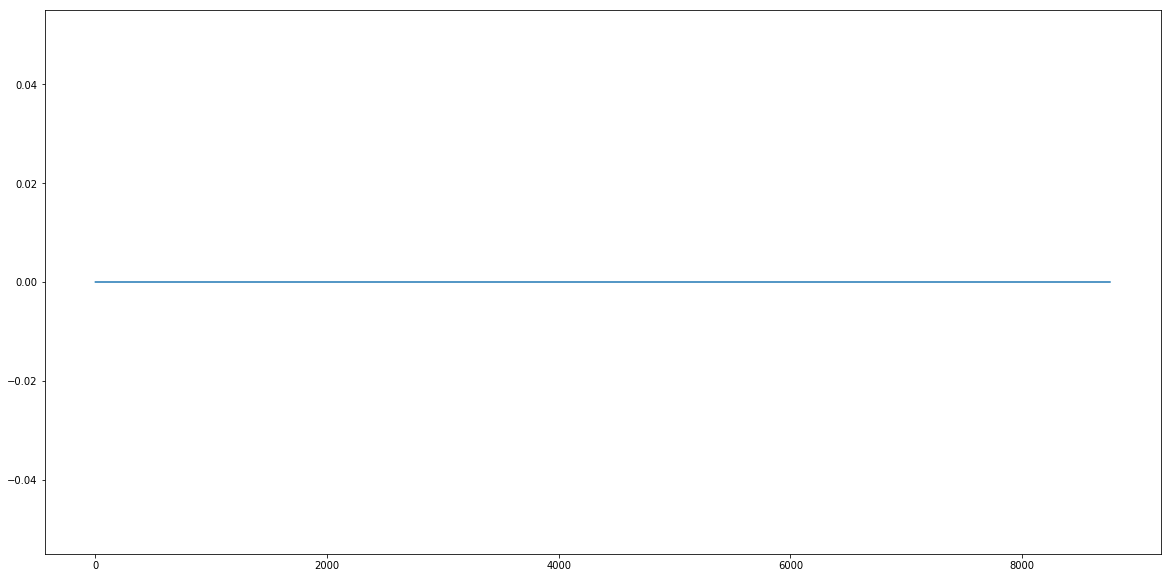

In [91]:
create_plot(RNG_df)